
# Trackintel case study - Tracking dataset comparison
This notebook presents a case-study to jointly analyse four different tracking datasets using [trackintel](https://github.com/mie-lab/trackintel). 
Three of the datasets that are used in this case study can not be published to protect the privacy of the participants. You can find an executable example notebook for trackintel here: [binder](https://mybinder.org/v2/gh/mie-lab/trackintel/HEAD?urlpath=https%3A%2F%2Fgithub.com%2Fmie-lab%2Ftrackintel%2Fblob%2Fmaster%2Fexamples%2Ftrackintel_basic_tutorial.ipynb) [code](https://github.com/mie-lab/trackintel/blob/master/examples/trackintel_basic_tutorial.ipynb)

## Imports

In [19]:
import os, sys
from collections import defaultdict
import pickle
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pytz
import json
import seaborn as sns
from shapely.geometry import Point, Polygon
from sqlalchemy import create_engine

import trackintel as ti
from trackintel.analysis.tracking_quality import temporal_tracking_quality
from trackintel.analysis.modal_split import calculate_modal_split
from trackintel.visualization.modal_split import plot_modal_split

In [20]:
out_path = "../../temp"
os.makedirs(out_path, exist_ok=True)

# path_to_geolife = "~/Downloads/Geolife Trajectories 1.3/Data"
path_to_geolife = r"E:\Geolife Trajectories 1.3\Data"

DBLOGIN_FILE_GC = "../../dblogin_commit.json"
DBLOGIN_FILE_yumuv = "../../dblogin_mielab.json"

with open(DBLOGIN_FILE_GC) as json_file:
    LOGIN_DATA_GC = json.load(json_file)

with open(DBLOGIN_FILE_yumuv) as json_file:
    LOGIN_DATA_YUMUV = json.load(json_file)

engine_gc = create_engine("postgresql://{user}:{password}@{host}:{port}/{database}".format(**LOGIN_DATA_GC))
engine_yumuv = create_engine("postgresql://{user}:{password}@{host}:{port}/{database}".format(**LOGIN_DATA_YUMUV))
engine_casestudy = create_engine(
    "postgresql://{user}:{password}@{host}:{port}/case_study_cache".format(**LOGIN_DATA_YUMUV)
)

CRS_WGS84 = "epsg:4326"

In [21]:
studies = ["gc1", "gc2", "yumuv_graph_rep", "geolife"]

# Full names for plotting
study_mapping = {
    "gc1": "Green Class 1",
    "gc2": "Green Class 2",
    "yumuv_graph_rep": "Yumuv",
    "geolife": "Geolife",
}

In [22]:
# filter for debugging (~2 users per dataset)
filter_sql = """where user_id = ANY('{"155", "51", "58", "1729", "1761", "2379ddac-f662-49a5-84be-6fae5c91a7e3", "e09fad5f-5b4b-4af5-a24d-0c0ef705199a", "c9aa08e2-1a5d-4d41-ae62-6110a9072b23", "15956", "15604"}'::text[])"""

# Part 1: Dataset loading and preprocessing

## Datasets
We include the data from four tracking studies with two different tracking data types.

### Green Class 1 & 2 
The Green Class 1 & 2 studies were conducted in collaboration with the Swiss Federal Railway Systems (SBB) under the project name [SBB Green Class](https://www.researchgate.net/publication/335858551_Analysis_framework_and_results_of_the_SBB_Green_Class_pilot_studies)
In both studies, participants were given full access to all public transport in Switzerland. In addition, the participants from the first Green Class study (Green Class 1) received an electric vehicle and the ones from the second study (Green Class 2) an e-bike. Study participants were tracked with a GNSS-based application (app) that provides partially preprocessed data as staypoints and triplegs.
### Geolife
The first study is the open-source [Geolife dataset](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F) that covers the movement of employees of Microsoft Research Asia. The dataset is from about 2012 and was still recorded with dedicated GPS-only trackers. As the study took place in an urban area the GPS was unreliable and there are many gaps in the dataset. However, Geolife is still one of the few publicly available tracking datasets.

### Yumuv
The [yumuv](https://www.research-collection.ethz.ch/handle/20.500.11850/521380) study investigated the impact of a [Mobility-as-a-Service app](https://yumuv.ch/en) that integrates shared e-scooters, e-bikes and public transport. In the yumuv study, participants were divided into control and treatment group and were tracked for three months using an app that already provides staypoints and triplegs.


# Import data
One main advantage of trackintel is its ability to standardize the preprocessing of tracking data. For this, the different datasets have to be imported to geopandas dataframes that fulfill the requirements described [here](https://trackintel.readthedocs.io/en/latest/modules/model.html).

The trackintel data model consists of these different classes:

- positionfixes [pfs]: Raw GPS data.
- staypoints [sp]: Locations where a user spent a minimal time.
- triplegs [tpls]: Segments covered with one mode of transport.
- locations [loc]: Clustered staypoints.
- trips: Segments between consecutive activity staypoints (special staypoints that are not just waiting points).
- tours: Sequences of trips which start and end at the same location (if the column ‘journey’ is True, this location is home).

The Geolife dataset consists of only positionfixes while the other datasets are already processed to staypoints and triplegs by the tracking app. We will now import all datasets and combine them on the staypoints / triplegs level


## Import Geolife
Geolife is an important benchmark dataset. Trackintel therefore offers a dedicated function that reads in the Geolife dataset. The import function takes care of the required column format and names.


In [23]:
import trackintel
from trackintel.io.dataset_reader import read_geolife

pfs_geolife, _ = read_geolife(path_to_geolife, print_progress=True)
pfs_geolife.head(3)

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [03:04<00:00,  1.02s/it]


,elevation,tracked_at,geom,user_id,accuracy
id,,,,,
0,149.9616,2008-10-23 02:53:04+00:00,POINT (116.31842 39.98470),0,NaN
1,149.9616,2008-10-23 02:53:10+00:00,POINT (116.31845 39.98468),0,NaN
2,149.9616,2008-10-23 02:53:15+00:00,POINT (116.31842 39.98469),0,NaN


### Geolife - Generate staypoints
We generate staypoints from the positionfixes and define all staypoints as relevant activities if they are longer than 25 minutes.

In [24]:
# extract staypoints
pfs_geolife, sp_geolife = pfs_geolife.as_positionfixes.generate_staypoints(
    gap_threshold=24 * 60,
    include_last=True,
    print_progress=True,
    dist_threshold=200,
    time_threshold=30,
    n_jobs=4,
)
sp_geolife["study"] = "Geolife"

# add activity flag to staypoints
sp_geolife = sp_geolife.as_staypoints.create_activity_flag(method="time_threshold", time_threshold=25)
sp_geolife.head(3)

C:\Users\henry\.conda\envs\geodev\lib\site-packages\trackintel\preprocessing\positionfixes.py:111: UserWarning: 146900 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [02:39<00:00,  1.14it/s]


,user_id,started_at,finished_at,elevation,geom,study,is_activity
id,,,,,,,
0,0,2008-10-23 03:03:45+00:00,2008-10-23 04:08:07+00:00,61.7220,POINT (116.29917 39.98341),Geolife,True
1,0,2008-10-23 04:32:52+00:00,2008-10-23 09:42:25+00:00,53.9496,POINT (116.32451 39.99967),Geolife,True
2,0,2008-10-23 11:10:42+00:00,2008-10-24 02:10:09+00:00,26.8224,POINT (116.32105 40.00917),Geolife,True


### Geolife - Generate triplegs

In [25]:
%%time
pfs_geolife, tpls_geolife = pfs_geolife.as_positionfixes.generate_triplegs(
    sp_geolife, method="between_staypoints", gap_threshold=25
)
tpls_geolife["study"] = "Geolife"
tpls_geolife.head(3)

C:\Users\henry\.conda\envs\geodev\lib\site-packages\trackintel\preprocessing\positionfixes.py:504: UserWarning: The positionfixes with ids [ 2894106  2894107  3826247  3826248  6900863  6900864  6909024  6909025
  7754881  7754882 11128882 11128883 11608868 11608869 14216369 14216370
 14411384 14411385 15674472 15674473 16477191 16477192 17290728 17290729] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


CPU times: total: 8min 19s
Wall time: 8min 19s


,user_id,started_at,finished_at,geom,study
id,,,,,
0,0,2008-10-23 02:53:04+00:00,2008-10-23 03:03:40+00:00,"LINESTRING (116.31842 39.98470, 116.31845 39.9...",Geolife
1,0,2008-10-23 04:08:07+00:00,2008-10-23 04:32:47+00:00,"LINESTRING (116.28680 39.99578, 116.28545 39.9...",Geolife
2,0,2008-10-23 09:42:25+00:00,2008-10-23 11:10:37+00:00,"LINESTRING (116.32016 40.00478, 116.32039 40.0...",Geolife


## Import Green Class 1 & 2
The green class datasets are stored in a postgis database and were already preprocessed to staypoints (static behavior) and triplegs (movement). To use them with trackintel, the data has to be adjusted to the data model. This means to create a geodataframe with the correct column names and timezone aware timestamps.


### Green class - Staypoints

In [43]:
sp_gc = []
for study in ["gc1", "gc2"]:
    # download data
    sp_temp = gpd.GeoDataFrame.from_postgis(
        sql=f"""SELECT id, user_id, started_at, finished_at, geometry_raw, purpose_validated FROM {study}.staypoints
        where started_at <= finished_at""",
        con=engine_gc,
        geom_col="geometry_raw",
        index_col="id",
    )

    # transform to trackintel dataframe
    sp_temp = ti.io.read_staypoints_gpd(
        sp_temp,
        geom_col="geom",
        tz="UTC",
        crs=CRS_WGS84,
        mapper={"geometry_raw": "geom", "purpose_validated": "purpose"},
    )

    # green class specific definition of activities
    sp_temp = sp_temp.as_staypoints.create_activity_flag(method="time_threshold", time_threshold=25)
    meaningful_purpose = ~sp_temp["purpose"].isin(["wait", "unknown"])
    sp_temp.loc[meaningful_purpose, "is_activity"] = True

    # keep study as attribute
    sp_temp["study"] = study_mapping[study]

    sp_gc.append(sp_temp)
    
sp_temp.head(3)

,user_id,started_at,finished_at,geom,purpose,is_activity,study
id,,,,,,,
3644805,2379ddac-f662-49a5-84be-6fae5c91a7e3,2017-09-17 12:57:18.869999+00:00,2017-09-17 15:55:03.536000+00:00,POINT (8.21500 47.47649),leisure,True,Green Class 2
3680485,2379ddac-f662-49a5-84be-6fae5c91a7e3,2017-09-28 14:41:47.967000+00:00,2017-09-28 16:11:56.680000+00:00,POINT (8.55968 47.29059),errand,True,Green Class 2
3680768,2379ddac-f662-49a5-84be-6fae5c91a7e3,2017-09-28 16:22:26.680000+00:00,2017-09-28 16:32:23.947999+00:00,POINT (8.56582 47.28667),unknown,False,Green Class 2


### Green class - Triplegs

In [170]:
tpls_gc = []
for study in ["gc1", "gc2"]:
    # downlaod data using geopandas
    tpls_temp = gpd.GeoDataFrame.from_postgis(
        sql=f"""SELECT id, user_id, started_at, finished_at, mode_validated as mode, mode_validated as mode_detailed, 
        geometry FROM {study}.triplegs where ST_isValid(geometry)""",
        con=engine_gc,
        crs=CRS_WGS84,
        geom_col="geometry",
        index_col="id",
    )
    # transform to trackintel dataframe
    tpls_temp = ti.io.read_triplegs_gpd(
        tpls_temp,
        geom_col="geom",
        crs=CRS_WGS84,
        tz="UTC",
        mapper={"geometry": "geom"},
    )
    # keep study as attribute
    tpls_temp["study"] = study_mapping[study]

    tpls_gc.append(tpls_temp)

tpls_temp.head(3)

,user_id,started_at,finished_at,mode,mode_detailed,geom,study
id,,,,,,,
3870150,7339c9ea-796f-490a-94bc-1fc3880cee79,2017-11-28 15:21:48.119999+00:00,2017-11-28 15:26:42.779999+00:00,Mode::Walk,Mode::Walk,"LINESTRING (7.90960 47.34585, 7.90960 47.34585...",Green Class 2
3861702,7339c9ea-796f-490a-94bc-1fc3880cee79,2017-11-25 16:04:25.017999+00:00,2017-11-25 16:05:40.017999+00:00,Mode::Car,Mode::Car,"LINESTRING (7.87884 47.30623, 7.87769 47.30591...",Green Class 2
3863208,7339c9ea-796f-490a-94bc-1fc3880cee79,2017-11-26 10:34:53.278111+00:00,2017-11-26 10:40:11.085000+00:00,Mode::Walk,Mode::Walk,"LINESTRING (8.08622 47.39315, 8.08631 47.39313...",Green Class 2


## Import yumuv
The yumuv data is stored in a postgis database and already available as staypoints and triplegs. To use them with trackintel, the data has to be adjusted to the data model. This means to create a geodataframe with the correct column names and timezone aware timestamps. We furthermore conduct two additional preprocessing steps: 
- We filter the tracking duration to the duration of the study which took place for most users from the 13th of July 2020 to the 15th of November 2020.
- We offset the user ids by a constant to be able to combine the data later with the other datasets without overlaps.

### yumuv - Staypoints

In [28]:
min_date = datetime.datetime(year=2020, month=7, day=13, tzinfo=pytz.utc)
max_date = datetime.datetime(year=2020, month=11, day=15, tzinfo=pytz.utc)

In [29]:
sp_yumuv = ti.io.read_staypoints_postgis(
    "select id, user_fk, started_at, finished_at, geometry from yumuv.staypoint",
    con=engine_yumuv,
    geom_col="geometry",
    crs=CRS_WGS84,
    index_col="id",
    tz="UTC",
    mapper={"user_fk": "user_id"},
)
sp_yumuv = sp_yumuv.rename({"geometry": "geom"}, axis=1).set_geometry("geom") # trackintel issue #409

sp_yumuv["study"] = "Yumuv"

# yumuv specific definition of activities
sp_yumuv = sp_yumuv.as_staypoints.create_activity_flag(time_threshold=25)

# offset user id
sp_yumuv["user_id"] = sp_yumuv["user_id"] + 10000

# filter study duration
sp_date_flag = (sp_yumuv["started_at"] >= min_date) & (sp_yumuv["finished_at"] <= max_date)
sp_yumuv = sp_yumuv[sp_date_flag]

### yumuv - Triplegs

In [30]:
tpls_yumuv = ti.io.postgis.read_triplegs_postgis(
    """select distinct on (id) id, user_fk, started_at, finished_at, track_mode_corrected, 
    geometry FROM yumuv.tripleg where ST_isvalid(geometry)""",
    con=engine_yumuv,
    geom_col="geometry",
    crs=CRS_WGS84,
    index_col="id",
    tz="UTC",
    mapper={"user_fk": "user_id"},
)
tpls_yumuv = tpls_yumuv.rename({"geometry": "geom", "track_mode_corrected": "mode"}, axis=1).set_geometry("geom")
tpls_yumuv["study"] = "Yumuv"

# offset user id
tpls_yumuv["user_id"] = tpls_yumuv["user_id"] + 10000

# filter study duration
tpls_date_flag = (tpls_yumuv["started_at"] >= min_date) & (tpls_yumuv["finished_at"] <= max_date)
tpls_yumuv = tpls_yumuv[tpls_date_flag]

## Combine studies
All datasets are now loaded into the trackintel framework and all tracking data is represented as `staypoints` and `triplegs`. We can now represent all studies in a joint `staypoints` and a joint `triplegs` dataframe and process all studies jointly. To allow the joint analysis we have to perform the following steps:
- All staypoints and triplegs are combined in a single dataframe respectively.
- All user ids are represented as strings to have an id column with a single data type.
- We offset the ids of staypoints and triplegs so that they are unique across studies.

Furthermore we simplify the geometry of triplegs to reduce computation time.

### All studies - combine staypoints

In [31]:
staypoints = pd.concat([sp_geolife] + sp_gc + [sp_yumuv])
staypoints["user_id"] = staypoints["user_id"].astype(str)

### All studies - combine triplegs

In [32]:
triplegs = pd.concat([tpls_geolife] + tpls_gc + [tpls_yumuv])
triplegs["user_id"] = triplegs["user_id"].astype(str)

In [33]:
triplegs["geom"] = triplegs.simplify(1e-5, preserve_topology=False)

offset ids to ensure unique IDs

In [34]:
for ix, study in enumerate(study_mapping.values()):
    sp_study_flag = staypoints["study"] == study
    tpls_study_flag = triplegs["study"] == study

    staypoints.loc[sp_study_flag].index = staypoints.loc[sp_study_flag].index + ix * 10e7
    triplegs.loc[tpls_study_flag].index = triplegs.loc[tpls_study_flag].index + ix * 10e7

In [46]:
# show a staypoint for each study (without user_id and geometry due to privacy)
staypoints[['started_at', 'finished_at', 'study', 'is_activity', 'purpose']].groupby('study').head(1)

,started_at,finished_at,study,is_activity,purpose
id,,,,,
0,2008-10-23 03:03:45+00:00,2008-10-23 04:08:07+00:00,Geolife,True,NaN
3202998,2017-04-01 10:52:26.184999+00:00,2017-04-01 11:35:56.184000+00:00,Green Class 1,True,errand
3644805,2017-09-17 12:57:18.869999+00:00,2017-09-17 15:55:03.536000+00:00,Green Class 2,True,leisure
7462707,2020-10-21 13:15:23+00:00,2020-10-21 15:21:29+00:00,Yumuv,True,NaN


Finally we create a table that matches user ids to studies

In [47]:
user_study_matching = staypoints[["user_id", "study"]].drop_duplicates()
user_study_matching = user_study_matching.set_index("user_id")


# Joint preprocessing
The representation of human mobility as `staypoints` and `triplegs` is often not enough for a detailed analysis. We now use trackintel to process `staypoints` and `triplegs` futher into `trips`, `tours` and `locations`. 
![Trackintel hierarchical data model](https://raw.githubusercontent.com/mie-lab/trackintel/master/docs/assets/hierarchy.png)
## create trips

In [48]:
staypoints, triplegs, trips = ti.preprocessing.triplegs.generate_trips(
    staypoints=staypoints, triplegs=triplegs, gap_threshold=15, add_geometry=True
)

C:\Users\henry\.conda\envs\geodev\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [49]:
trips = trips.join(user_study_matching, on="user_id")

### All studies - create locations

In [50]:
staypoints, locations = ti.preprocessing.generate_locations(
    staypoints,
    epsilon=30,
    num_samples=1,
    distance_metric="haversine",
    print_progress=True,
    n_jobs=4,
)

100%|██████████████████████████████████████████████████████████████████████████████| 1172/1172 [00:21<00:00, 54.06it/s]
C:\Users\henry\.conda\envs\geodev\lib\site-packages\pandas\core\apply.py:1137: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  mapped = lib.map_infer(


In [51]:
locations = locations.join(user_study_matching, on="user_id")

### All studies - create tours

In [52]:
trips, tours = ti.preprocessing.generate_tours(trips, staypoints=staypoints, print_progress=True)
tours["started_at"] = pd.to_datetime(tours["started_at"])
tours["finished_at"] = pd.to_datetime(tours["finished_at"])

User trip generation: 100%|████████████████████████████████████████████████████████| 1184/1184 [06:55<00:00,  2.85it/s]


In [53]:
tours = tours.join(user_study_matching, on="user_id")

## Write intermediate outputs to database

In [54]:
print("check that index is unique:")
assert staypoints.index.is_unique
assert triplegs.index.is_unique
assert trips.index.is_unique
assert tours.index.is_unique
assert locations.index.is_unique

check that index is unique:


In [55]:
staypoints.as_staypoints.to_postgis("staypoints", con=engine_casestudy, if_exists="replace")

In [56]:
triplegs.as_triplegs.to_postgis("triplegs", con=engine_casestudy, if_exists="replace", chunksize=10000)

In [57]:
locations.as_locations.to_postgis("locations", con=engine_casestudy, if_exists="replace")

In [58]:
trips.as_trips.to_postgis("trips", con=engine_casestudy, if_exists="replace")

In [59]:
tours.as_tours.to_postgis("tours", con=engine_casestudy, if_exists="replace")

## Load from cache

In [32]:
debug_flag = False

In [33]:
if debug_flag:
    staypoints = ti.io.postgis.read_staypoints_postgis(
        f"SELECT * from staypoints {filter_sql}",
        con=engine_casestudy,
        geom_col="geom",
        index_col="id",
    )
    triplegs = ti.io.postgis.read_triplegs_postgis(
        f"SELECT * from triplegs {filter_sql} and ST_isvalid(geom)",
        con=engine_casestudy,
        geom_col="geom",
        index_col="id",
    )
    locations = ti.io.postgis.read_locations_postgis(
        f"SELECT * from locations {filter_sql}", con=engine_casestudy, index_col="id"
    )
    trips = ti.io.postgis.read_trips_postgis(f"SELECT * FROM trips {filter_sql}", con=engine_casestudy, index_col="id")
    tours = ti.io.postgis.read_tours_postgis(f"SELECT * FROM tours {filter_sql}", con=engine_casestudy, index_col="id")

# Part 2: Dataset comparison

## 1) Simple Statistics

Number of users, number of trips, number of trips by user, etc

In [60]:
overview_df = pd.DataFrame(index=study_mapping.values())

overview_df["nr_user"] = staypoints.groupby(by=["study"]).agg({"user_id": "nunique"})
nr_user = overview_df["nr_user"]

# nb staypooints
overview_df["nr_sp"] = staypoints.groupby(by=["study"]).size()
overview_df["nr_staypoints_per_user"] = overview_df["nr_sp"] / nr_user

# nb triplegs
overview_df["nr_tpls"] = triplegs.groupby(by=["study"]).size()
overview_df["nr_triplegs_per_user"] = overview_df["nr_tpls"] / nr_user

# nb trips
overview_df["nr_trips"] = trips.groupby(by=["study"]).size()
overview_df["nr_trips_per_user"] = overview_df["nr_trips"] / nr_user
# nb locations

overview_df["nr_loc"] = locations.groupby(by=["study"]).size()
overview_df["nr_locations_per_user"] = overview_df["nr_loc"] / nr_user

# nb tours
overview_df["nr_tours"] = tours.groupby(by=["study"]).size()
overview_df["nr_tours_per_user"] = overview_df["nr_tours"] / nr_user

In [61]:
overview_df

,nr_user,nr_sp,nr_staypoints_per_user,nr_tpls,nr_triplegs_per_user,nr_trips,nr_trips_per_user,nr_loc,nr_locations_per_user,nr_tours,nr_tours_per_user
Green Class 1,139,326926,2351.985612,465189,3346.683453,241827,1739.762590,104497,751.776978,94978,683.294964
Green Class 2,50,87884,1757.680000,128618,2572.360000,61421,1228.420000,35715,714.300000,22709,454.180000
Yumuv,806,326271,404.802730,502292,623.191067,199735,247.810174,127320,157.965261,83019,103.001241
Geolife,177,28877,163.146893,30205,170.649718,30199,170.615819,13575,76.694915,7184,40.587571


## 2) Trip characteristics

* How many trips comprise one tour on average? How many triplegs comprise a trip?
* What is the average trip duration / distance?

### Number of hops in tours

In [62]:
tours["nb_hops"] = tours["trips"].apply(lambda x: len(x))
overview_df["avg_hops_tours"] = tours.groupby("study")["nb_hops"].mean()

In [115]:
overview_df["avg_hops_tours"]

Green Class 1    2.725178
Green Class 2    2.656656
Yumuv            2.112806
Geolife          2.373469
Name: avg_hops_tours, dtype: float64

### Trip duration

In [116]:
trips["duration_s"] = (trips["finished_at"] - trips["started_at"]).dt.total_seconds() / 3600

In [156]:
overview_df[["mean_trip_dur", "std_trip_dur"]] = trips.groupby("study")["duration_s"].aggregate(["mean", "std"])

In [118]:
overview_df[["mean_trip_dur", "std_trip_dur"]]

,mean_trip_dur,std_trip_dur
Green Class 1,0.52,0.73
Green Class 2,0.51,0.75
Yumuv,0.68,0.91
Geolife,0.64,0.94


### Overall tracking period and number of trips per day per user

In [120]:
min_max_times_by_user = trips.groupby(["study", "user_id"]).aggregate({"started_at": "min", "finished_at": "max"})
duration_by_user = (min_max_times_by_user["finished_at"] -
                    min_max_times_by_user["started_at"]).dt.total_seconds() / (3600 * 24)

overview_df[["mean_tracking_period", "std_tracking_period"]] = duration_by_user.groupby("study").aggregate(
    ["mean", "std"]
)

In [121]:
overview_df[["mean_tracking_period", "std_tracking_period"]]

,mean_tracking_period,std_tracking_period
Green Class 1,401.639038,59.289224
Green Class 2,314.203054,76.458555
Yumuv,87.393827,38.954972
Geolife,193.216082,443.133363


# Todo: decide on one of the two cells

In [66]:
# average trips per day on days with data
trips_temp = trips.set_index("started_at")
nr_trips_per_user_per_day = (
    trips_temp.groupby(["study", "user_id", pd.Grouper(freq="D")]).size().groupby("study").mean()
)
overview_df["nr_trips_per_user_per_day"] = nr_trips_per_user_per_day

In [113]:
overview_df["nr_trips_per_user_per_day"]

Green Class 1    4.888357
Green Class 2    4.770934
Yumuv            3.413282
Geolife          2.758403
Name: nr_trips_per_user_per_day, dtype: float64

In [67]:
# average trips per day over full tracking period
nr_trips_per_user_per_day = (trips.groupby(["study", "user_id"]).size() / duration_by_user).groupby("study").mean()

In [114]:
nr_trips_per_user_per_day

study
Geolife          1.701115
Green Class 1    4.319424
Green Class 2    3.797688
Yumuv            3.131575
dtype: float64

### Trip distance

In [69]:
triplegs["length_in_m"] = ti.geogr.distances.calculate_haversine_length(triplegs)

In [122]:
metrics_per_trip = triplegs.groupby(["study", "trip_id"]).agg({"trip_id": "count", "length_in_m": "sum"})

overview_df[["nr_legs_per_trip", "avg_trip_length", "std_trip_length"]] = metrics_per_trip.groupby("study").agg(
    {"trip_id": "mean", "length_in_m": ["mean", "std"]}
)

In [112]:
overview_df[["nr_legs_per_trip", "avg_trip_length", "std_trip_length"]]

,nr_legs_per_trip,avg_trip_length,std_trip_length
Green Class 1,1.923644,27353.308942,4.786795e+05
Green Class 2,2.094039,33656.574835,5.681591e+05
Yumuv,2.514616,16883.392911,1.004259e+05
Geolife,1.000000,36091.470623,3.163541e+06


### Tracking quality (temporal coverage)

In [123]:
triplegs_staypoints = pd.concat([triplegs, staypoints])
tracking_quality_by_user_study = triplegs_staypoints.groupby("study").apply(temporal_tracking_quality)
overview_df[["mean_tracking_quality", "std_tracking_quality"]] = tracking_quality_by_user_study.groupby("study")['quality'].agg(
    ["mean", "std"]
)

In [124]:
overview_df[["mean_tracking_quality", "std_tracking_quality"]]

,mean_tracking_quality,std_tracking_quality
Green Class 1,0.846013,0.170496
Green Class 2,0.753360,0.237378
Yumuv,0.766790,0.231347
Geolife,0.397451,0.317477


## 3) Finalize results in two tables

### 3.1) Simple dataset stats as pretty table

In [151]:
# basic info
overview_df.fillna(0, inplace=True)
df_basic = overview_df[
    [
        "nr_user",
        "mean_tracking_period",
        "std_tracking_period",
        "nr_loc",
        "nr_sp",
        "nr_tpls",
        "nr_trips",
        "nr_tours",
    ]
].astype(int)

In [152]:
# format mean tracking period and its std nicely
df_basic["Tracking period (std)"] = df_basic.apply(
    lambda x: f"{x['mean_tracking_period']} ({x['std_tracking_period']})", axis=1
)

In [153]:
# set column values for data type and tracking technology
df_basic.loc[["Green Class 1", "Green Class 2", "Yumuv"], "Input"] = "Staypoints, Triplegs"
df_basic.loc["Geolife", "Input"] = "Positionfixes"

df_basic.loc[["Green Class 1", "Green Class 2", "Yumuv"], "Study type"] = "GNSS (app)"
df_basic.loc["Geolife", "Study type"] = "GPS tracker"

In [154]:
# rename columns and index
df_basic = df_basic.rename(
    columns={
        "nr_user": "Users",
        "nr_loc": "Locations",
        "nr_sp": "Staypoints",
        "nr_tpls": "Triplegs",
        "nr_trips": "Trips",
        "nr_tours": "Tours",
    },
    index=study_mapping)
df_basic.drop(columns=["mean_tracking_period", "std_tracking_period"], inplace=True)

In [155]:
# select the columns in the right order
df_basic = df_basic[
    [
        "Users",
        "Tracking period (std)",
        "Input",
        "Study type",
        "Locations",
        "Staypoints",
        "Triplegs",
        "Trips",
        "Tours",
    ]
]

df_basic
# print(df_basic.to_latex())

,Users,Tracking period (std),Input,Study type,Locations,Staypoints,Triplegs,Trips,Tours
Green Class 1,139,401 (59),"Staypoints, Triplegs",GNSS (app),104497,326926,465189,241827,94978
Green Class 2,50,314 (76),"Staypoints, Triplegs",GNSS (app),35715,87884,128618,61421,22709
Yumuv,806,87 (38),"Staypoints, Triplegs",GNSS (app),127320,326271,502292,199735,83019
Geolife,177,193 (443),Positionfixes,GPS tracker,13575,28877,30205,30199,7184


### 3.2) Analysis results as pretty table

In [162]:
# Analysis table
df_detailed = overview_df[
    [
        "nr_trips_per_user_per_day",
        "mean_trip_dur",
        "std_trip_dur",
        "avg_hops_tours",
        "nr_legs_per_trip",
        "avg_trip_length",
        "std_trip_length",
        "mean_tracking_quality",
        "std_tracking_quality",
    ]
]

df_detailed = df_detailed.round(2)
df_detailed

,nr_trips_per_user_per_day,mean_trip_dur,std_trip_dur,avg_hops_tours,nr_legs_per_trip,avg_trip_length,std_trip_length,mean_tracking_quality,std_tracking_quality
Green Class 1,4.89,0.52,0.73,2.73,1.92,27390.82,479183.81,0.85,0.17
Green Class 2,4.77,0.51,0.75,2.66,2.09,33835.54,570125.17,0.75,0.24
Yumuv,3.41,0.68,0.91,2.11,2.51,16883.39,100425.90,0.77,0.23
Geolife,2.76,0.64,0.94,2.37,1.00,36092.18,3163593.53,0.40,0.32


In [164]:
# # format mean and its std nicely in a single cell
df_detailed["Trip distance (std)"] = df_detailed.apply(
    lambda x: f"{int(x['avg_trip_length'])} ({int(x['std_trip_length'])})", axis=1
)
df_detailed["Trip duration (std)"] = df_detailed.apply(lambda x: f"{x['mean_trip_dur']} ({x['std_trip_dur']})", axis=1)
df_detailed["Tracking quality (std)"] = df_detailed.apply(
    lambda x: f"{x['mean_tracking_quality']} ({x['std_tracking_quality']})", axis=1
)

In [165]:
df_detailed = df_detailed.rename(
    columns={
        "nr_trips_per_user_per_day": "Trips per day",
        "avg_hops_tours": "Trips per tour",
        "nr_legs_per_trip": "Legs per trip",
    }
)
df_detailed.drop(
    [
        "avg_trip_length",
        "std_trip_length",
        "mean_tracking_quality",
        "std_tracking_quality",
        "mean_trip_dur",
        "std_trip_dur",
    ],
    axis=1,
    inplace=True,
)

df_detailed
# print(df_detailed.to_latex())

,Trips per day,Trips per tour,Legs per trip,Trip distance (std),Trip duration (std),Tracking quality (std)
Green Class 1,4.89,2.73,1.92,27390 (479183),0.52 (0.73),0.85 (0.17)
Green Class 2,4.77,2.66,2.09,33835 (570125),0.51 (0.75),0.75 (0.24)
Yumuv,3.41,2.11,2.51,16883 (100425),0.68 (0.91),0.77 (0.23)
Geolife,2.76,2.37,1.00,36092 (3163593),0.64 (0.94),0.4 (0.32)


## 4) KDE plot for user tracking quality distribution

In [166]:
new_df = tracking_quality_by_user_study.reset_index(drop=False, level=0).drop("user_id", axis=1)
new_df = new_df.pivot(columns="study", values="quality")
new_df

study,Geolife,Green Class 1,Green Class 2,Yumuv
0,0.426798,0.866418,0.820881,0.838921
1,0.772387,0.974977,0.887259,0.372596
2,0.119809,0.975364,0.899003,0.888794
3,0.146686,0.807545,0.920321,0.980707
4,0.080984,0.929822,0.234912,0.956829
...,...,...,...,...
812,NaN,NaN,NaN,0.671191
813,NaN,NaN,NaN,0.945578
814,NaN,NaN,NaN,0.779364
815,NaN,NaN,NaN,0.748584


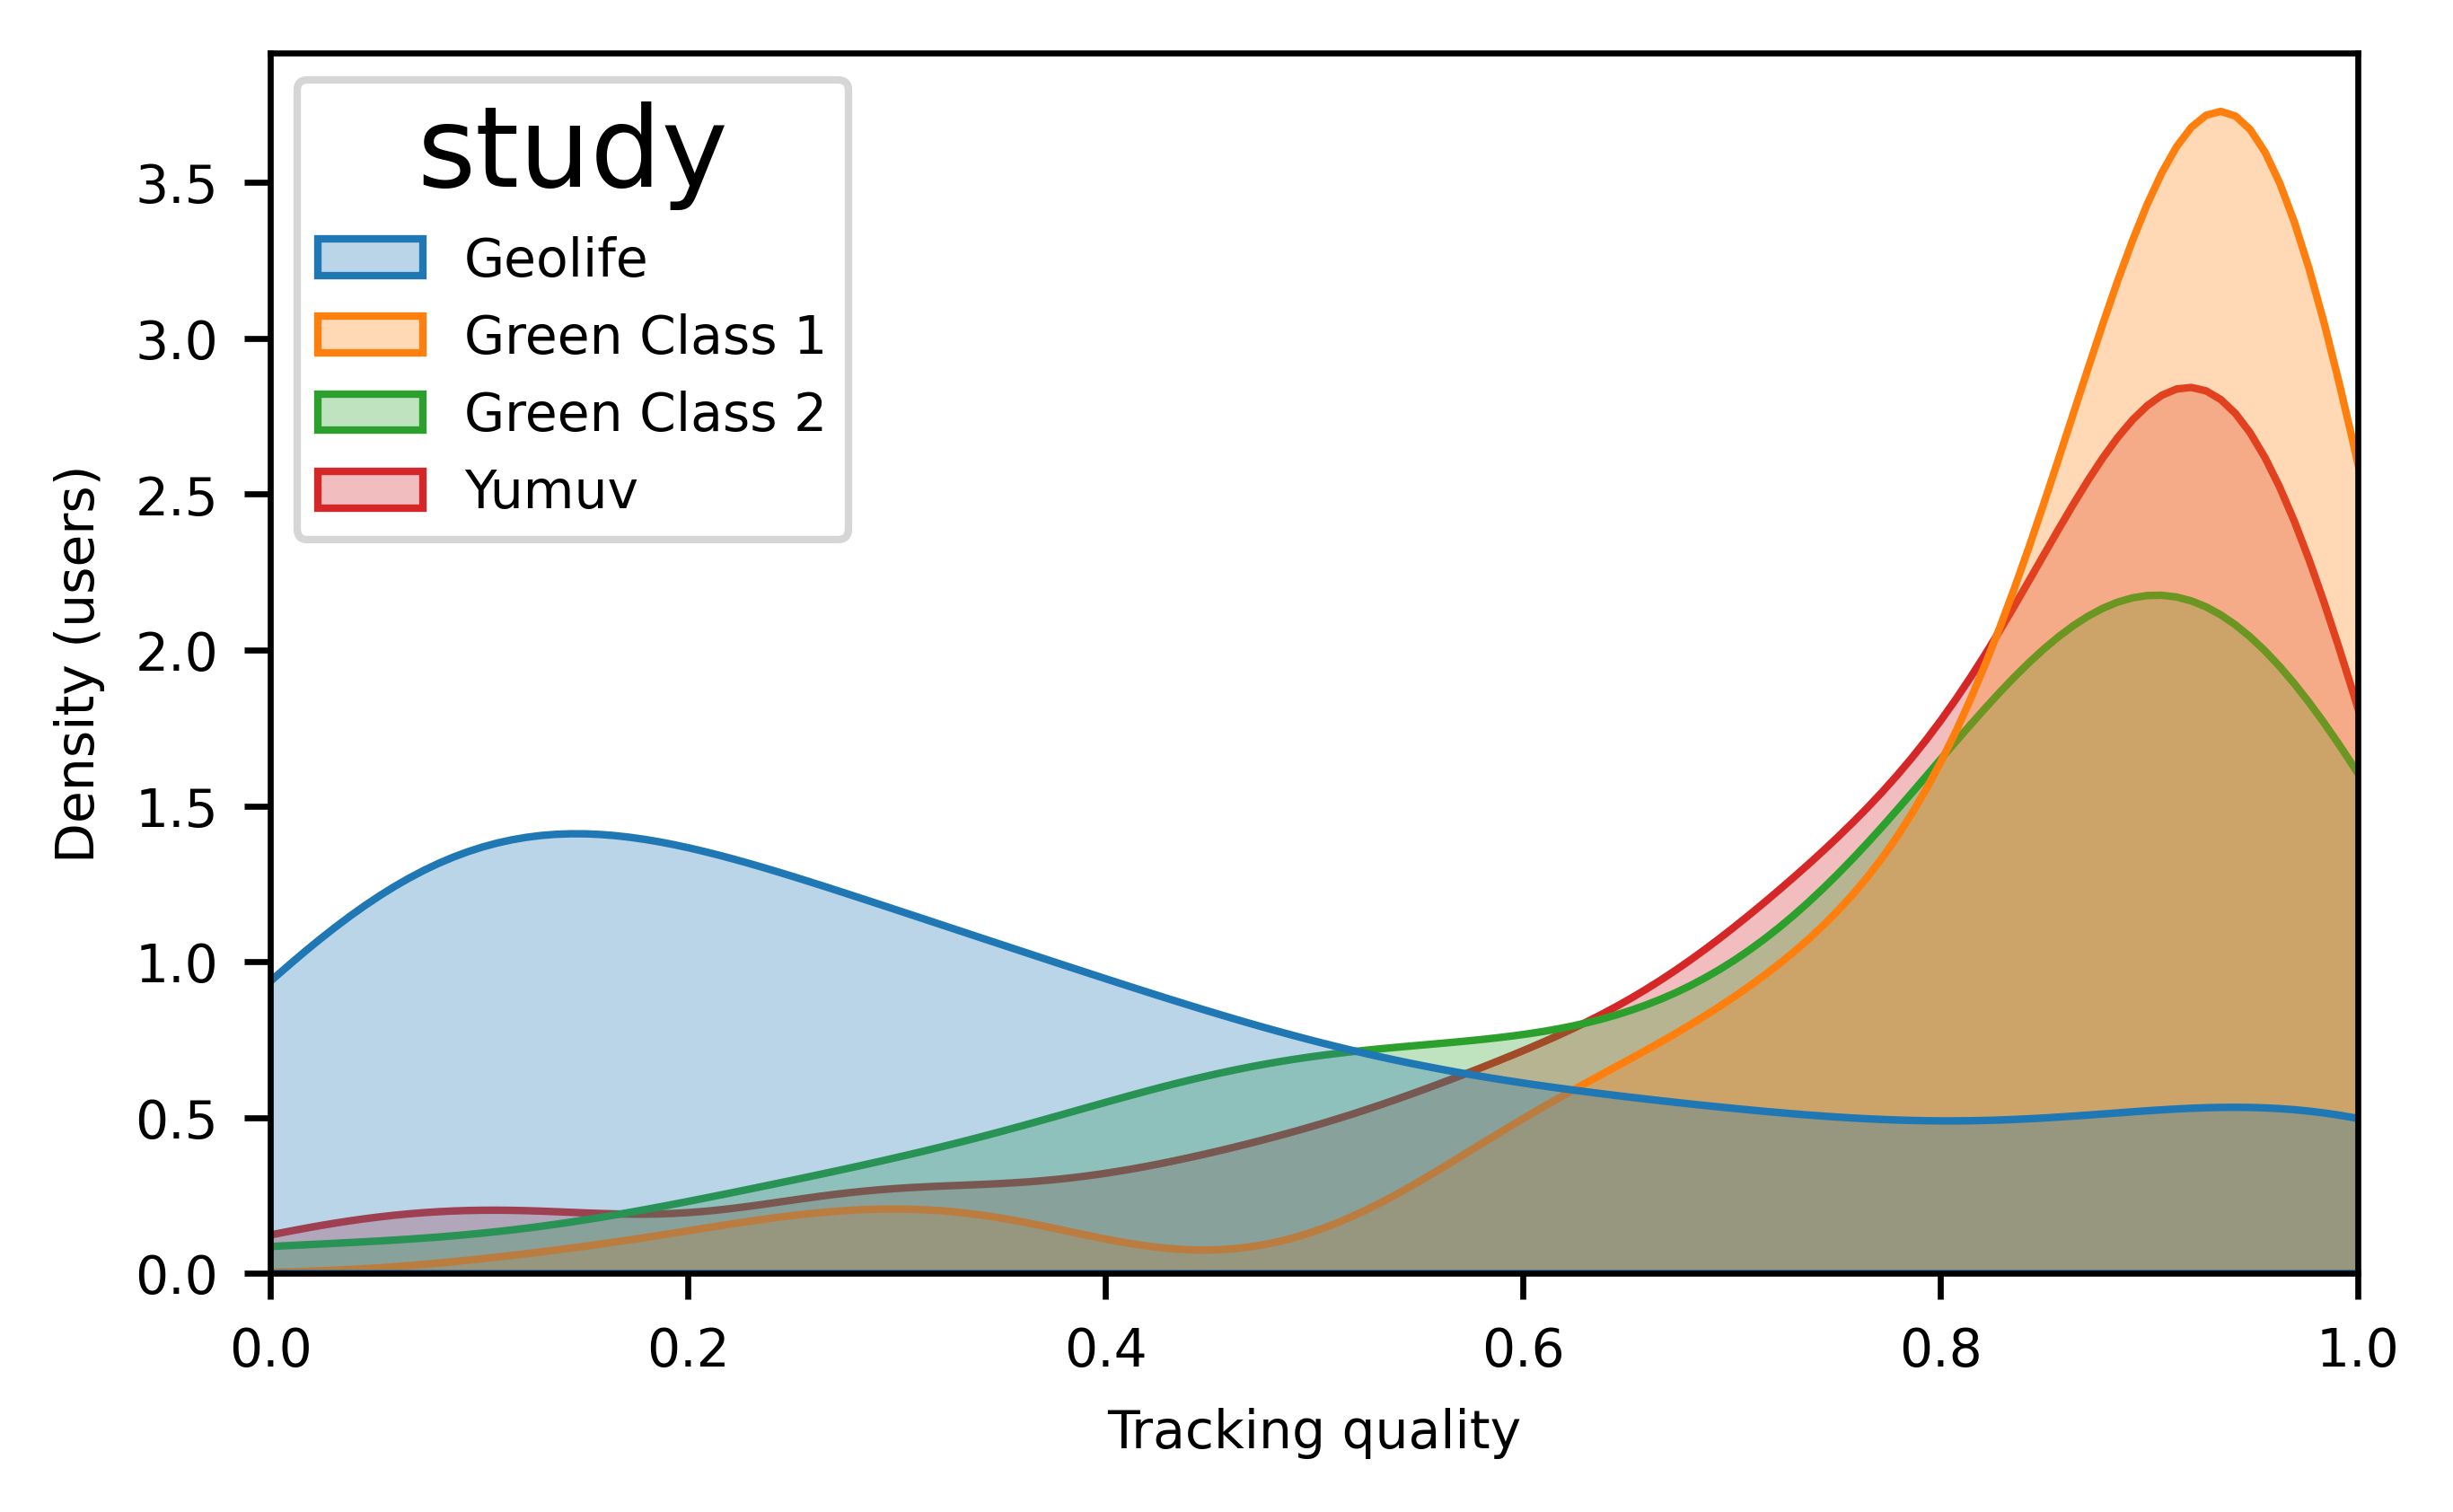

In [167]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.rcParams.update({"font.size": 15})
g = sns.kdeplot(
    data=new_df,
    fill=True,
    alpha=0.3,
    legend=True,
    common_grid=True,
    common_norm=False,
    ax=ax,
)

plt.ylabel("Density (users)")
plt.xlabel("Tracking quality")
sns.move_legend(g, "upper left")
plt.xlim(0, 1)
plt.savefig(os.path.join(out_path, "tracking_quality_kde.png"))
plt.show()

## 5) Modal split dataset comparison

### Get modal split for each study

#### Apply Trackintel function to get the modes for Geolife

In [78]:
is_geolife = triplegs["study"] == "Geolife"
tpls_geolife = triplegs[is_geolife]

In [79]:
# predict transport mode
triplegs.loc[is_geolife, "mode"] = ti.analysis.labelling.predict_transport_mode(triplegs[is_geolife])

In [80]:
# we need to map the mode labels from GC1 / GC2 / Yumuv to the ones from geolife
mode_to_category = {
    "Mode::Bicycle": "slow",
    "Mode::Car": "motorized",
    "Mode::Train": "fast",
    "Mode::Walk": "slow",
    "Mode::Tram": "motorized",
    "Mode::Bus": "motorized",
    "Mode::Airplane": "fast",
    "Mode::Coach": "motorized",
    "Mode::Ebicycle": "slow",
    "Mode::Boat": "slow",
    "Mode::Ecar": "motorized",
    "fast_mobility": "fast",
    "motorized_mobility": "motorized",
    "slow_mobility": "slow",
    "airplane": "fast",
    "bicycle": "slow",
    "boat": "slow",
    "bus": "motorized",
    "car": "motorized",
    "coach": "motorized",
    "ebicycle": "slow",
    "kick_scooter": "slow",
    "ecar": "motorized",
    "motorbike": "motorized",
    "ski": "slow",
    "train": "fast",
    "tram": "motorized",
    "walk": "slow",
    "fast": "fast",
    "motorized": "motorized",
    "slow": "slow",
}
# change mode labels with the above mapping
triplegs["mode"] = triplegs["mode"].map(mode_to_category)
triplegs.dropna(subset=["mode"], inplace=True)

### Get modal split by count, duration and distance

In [81]:
# count
modal_split_count = triplegs.groupby("study").apply(calculate_modal_split, metric="count", norm=True)
modal_split_count = modal_split_count.droplevel(1)
modal_split_count

mode,fast,motorized,slow
study,,,
Geolife,0.009270,0.409317,0.581413
Green Class 1,0.128245,0.377709,0.494046
Green Class 2,0.138213,0.257223,0.604564
Yumuv,0.067272,0.259749,0.672979


In [82]:
# duration
modal_split_duration = triplegs.groupby("study").apply(calculate_modal_split, metric="duration", norm=True)
modal_split_duration = modal_split_duration.droplevel(1)
modal_split_duration

mode,fast,motorized,slow
study,,,
Geolife,0.025935,0.467538,0.506527
Green Class 1,0.281664,0.474181,0.244155
Green Class 2,0.285285,0.320476,0.394239
Yumuv,0.144173,0.358140,0.497688


In [83]:
# distance
modal_split_list = []
for study, tpls in triplegs.groupby("study"):
    modal_split_distance = calculate_modal_split(tpls, metric="distance", norm=True)
    modal_split_distance["study"] = study
    modal_split_list.append(modal_split_distance)

modal_split_distance = pd.concat(modal_split_list).set_index("study")
modal_split_distance

mode,fast,motorized,slow
study,,,
Geolife,0.627340,0.297629,0.075030
Green Class 1,0.539562,0.421444,0.038994
Green Class 2,0.701996,0.230656,0.067348
Yumuv,0.451134,0.443738,0.105128


### Plotting

In [84]:
def plot_modal_split_comparison(name_df, modal_split_df):

    fig, ax = plt.subplots(figsize=(12, 8))
    modal_split_df.plot.bar(stacked=True, color=color, ax=ax)
    fs = 16
    plt.legend(loc="upper right", framealpha=1, fontsize=fs)
    plt.xlabel("Dataset", fontsize=fs)
    plt.ylabel("Modal split", fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.tight_layout()
    plt.savefig(os.path.join(out_path, f"modal_split_all_{name_df}.pdf"), bbox_inches="tight")
    plt.show()

In [85]:
triplegs["mode"].unique()

array(['slow', 'motorized', 'fast'], dtype=object)

In [86]:
# triplegs

# extent mode_to_category mapping with the upper case / colon versions
# further_cols = list(modal_split_count["gc1"].columns)
# for col in further_cols:
#    mode_to_category[col] = mode_to_category[col.split("::")[1].lower()]

In [87]:
colors = ["#1D2F6F", "#8390FA", "#6EAF46", "#FAC748"]
color = dict(zip(["fast", "motorized", "slow"], ["#1D2F6F", "#8390FA", "#6EAF46"]))
color

{'fast': '#1D2F6F', 'motorized': '#8390FA', 'slow': '#6EAF46'}

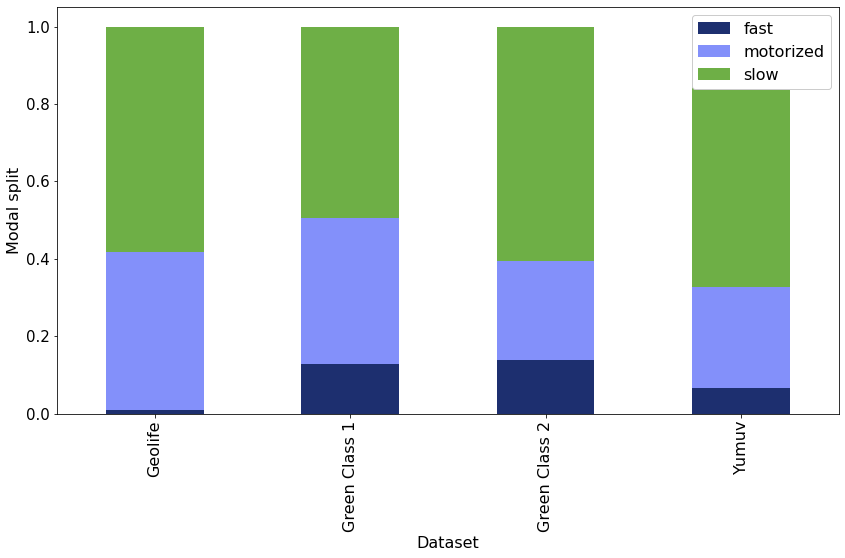

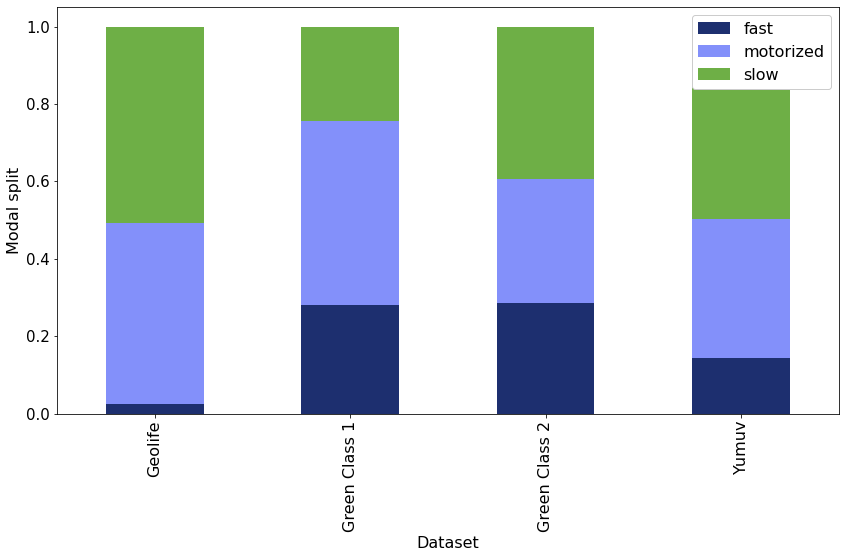

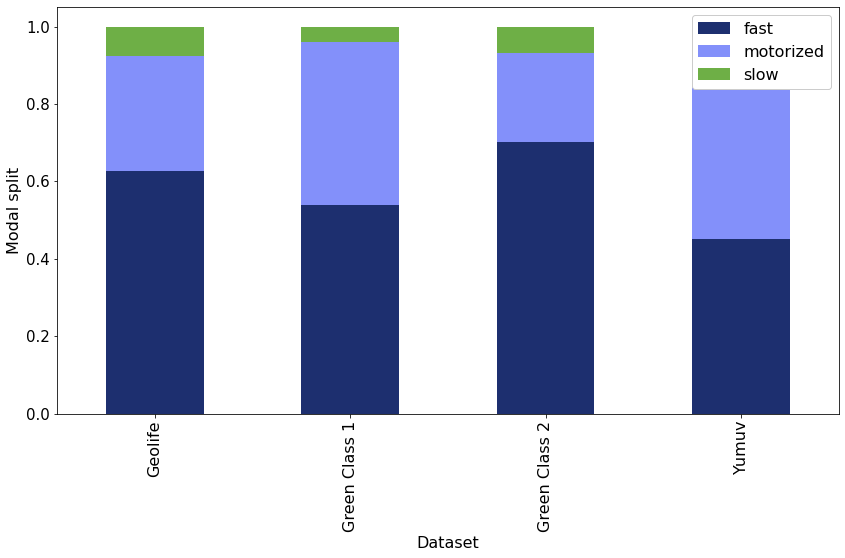

In [88]:
# plotting loop
for name_df, modal_split_df in zip(
    ["count", "duration", "distance"],
    [modal_split_count, modal_split_duration, modal_split_distance],
):
    plot_modal_split_comparison(name_df, modal_split_df)

## 6) Home / Work labeling

In [89]:
# DEFINE MAIN VARIABLE TO PLOT HERE
home_work_variable = "home"

#### Compute staypoint purpose for Geolife and Yumuv

In [90]:
yumuv_geolife_flag = staypoints["study"].isin(["Geolife", "Yumuv"])
# prefilter argument dict can be replaced with prefilter=False after the next patch
staypoints.loc[yumuv_geolife_flag, "purpose"] = ti.analysis.location_identifier(
    staypoints.loc[yumuv_geolife_flag], method="FREQ", pre_filter=False
)["purpose"]

In [91]:
sp_home = staypoints[staypoints["purpose"] == "home"].copy()
sp_work = staypoints[staypoints["purpose"] == "work"].copy()

#### Prepare data

In [92]:
# Use either the home staypoints or the work staypoints
if home_work_variable == "home":
    sp_study = sp_home.copy()
elif home_work_variable == "work":
    sp_study = sp_work.copy()

# convert timestamp columns
sp_study.loc[:, "started_at"] = sp_study.loc[:, "started_at"].dt.tz_convert("Europe/Paris")
sp_study.loc[:, "finished_at"] = sp_study.loc[:, "finished_at"].dt.tz_convert("Europe/Paris")

In [93]:
# chop up durations to minute-by-minute time series
sp_study_ = sp_study[["started_at", "finished_at", "study"]]

sp_study_["date"] = sp_study_.apply(lambda x: pd.date_range(x["started_at"], x["finished_at"], freq="min"), axis=1)
sp_study_expl = sp_study_.explode("date", ignore_index=True).drop(columns=["started_at", "finished_at"])

C:\Users\henry\AppData\Local\Temp\ipykernel_79688\1694343918.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_study_["date"] = sp_study_.apply(lambda x: pd.date_range(x["started_at"], x["finished_at"], freq="min"), axis=1)


In [94]:
# create hour&minute attributes used for aggregation later. Get Geolife in local time zone
geolife_flag = sp_study_expl["study"] == "Geolife"

sp_study_expl.loc[~geolife_flag, "hour"] = sp_study_expl.loc[~geolife_flag, "date"].dt.hour
sp_study_expl.loc[geolife_flag, "hour"] = sp_study_expl.loc[geolife_flag, "date"].dt.tz_convert("Asia/Shanghai").dt.hour
sp_study_expl["minute"] = sp_study_expl.date.dt.minute

#### Plotting

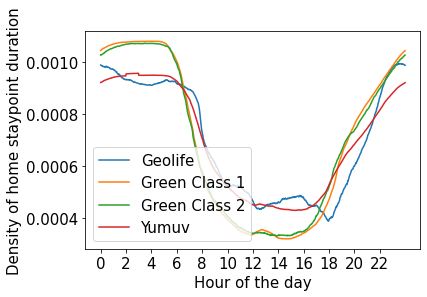

In [95]:
count_by_minute = pd.DataFrame(sp_study_expl.groupby(["study", "hour", "minute"]).size())
count_by_minute.index.rename(["study", "hour", "minute"], inplace=True)
count_by_minute.reset_index(inplace=True)
count_by_minute["minute_of_day"] = count_by_minute["hour"] * 60 + count_by_minute["minute"]


count_by_minute_pivot = count_by_minute.pivot(columns="study", index="minute_of_day", values=0)
count_by_minute_pivot = count_by_minute_pivot / count_by_minute_pivot.sum(axis=0)
count_by_minute_pivot.plot()
plt.xticks(np.arange(0, len(count_by_minute_pivot.index), 120), np.arange(0, 24, 2))
plt.legend(loc="lower left")
plt.ylabel(f"Density of {home_work_variable} staypoint duration")
plt.xlabel("Hour of the day")
plt.savefig(os.path.join(out_path, f"plot_activity_distribution_{home_work_variable}.pdf"))
plt.show()

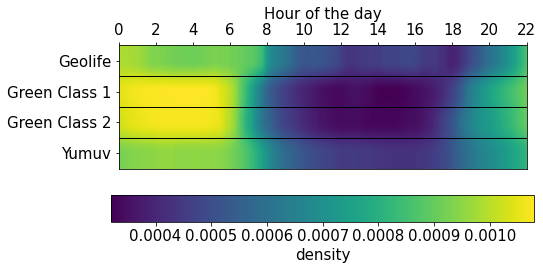

In [96]:
fig, ax = plt.subplots(figsize=(12, 4))
home_slots = count_by_minute_pivot.values.transpose()
plt.imshow(home_slots, aspect=100)
for i in range(4):
    plt.plot([0, home_slots.shape[1]], [i + 0.5, i + 0.5], c="black", lw=1)
plt.xlim(0, 24)
plt.yticks(np.arange(4), count_by_minute_pivot.columns)
plt.xlabel("Hour of the day")
ax.xaxis.tick_top()
ax.xaxis.tickpad = -2
ax.xaxis.set_label_position("top")
plt.xticks(np.arange(0, len(count_by_minute_pivot.index), 120), np.arange(0, 24, 2))
# ax.set_xticklabels(np.arange(0, len(minute_slots), 120), np.arange(0,24, 2))
cbar = plt.colorbar(orientation="horizontal", ax=ax, aspect=16)  # anchor=(-1, -1))
cbar.set_label(f"density")
plt.tight_layout()
plt.savefig(
    os.path.join(out_path, f"imshow_act_distribution_{home_work_variable}.pdf"),
    bbox_inches="tight",
)
plt.show()

## 7) Single user visualization

### 7.1 Visualize positionfixes, staypoints and triplegs

In [97]:
x_min = 116.2
x_max = 116.5
y_min = 39.8
y_max = 40.1
sw = Point(x_min, y_min)
se = Point(x_max, y_min)
ne = Point(x_max, y_max)
nw = Point(x_min, y_max)

study_area = gpd.GeoDataFrame(
    columns=["geometry"],
    data=[Polygon([sw, se, ne, nw])],
    geometry="geometry",
    crs="EPSG:4326",
)

In [98]:
# Load Geolife data of one user
tpls_vis = triplegs[triplegs["user_id"] == "51"].copy()
tpls_vis = ti.preprocessing.filter.spatial_filter(tpls_vis, study_area, method="within")

In [99]:
# Get staypoints as well for this user
sp_vis = staypoints[staypoints["user_id"] == "51"].copy()
sp_vis = ti.preprocessing.filter.spatial_filter(sp_vis, study_area, method="within")

In [100]:
# Get positionfixes for this user - using the pfs obtained with read_geolife function (see top of notebook)
pfs_vis = pfs_geolife[pfs_geolife["user_id"] == 51]
pfs_vis = ti.preprocessing.filter.spatial_filter(pfs_vis, study_area, method="within")
# Other option: Load from database that stores Geolife positionfixes
# sql = f"SELECT * FROM geolife.positionfixes WHERE user_id='51'"
# pfs_vis = ti.io.read_positionfixes_postgis(sql, con, index_col="id")

In [101]:
ti.visualization.plot_triplegs(
    tpls_vis,
    staypoints=sp_vis,
    plot_osm=True,
    positionfixes=pfs_vis,
    staypoints_radius=150,
    out_filename=os.path.join(out_path, "geolife_tpls_sp_pfs"),
)

#### Plot only positionfixes

In [102]:
ti.visualization.plot_positionfixes(pfs_vis, plot_osm=True, out_filename=os.path.join(out_path, "geolife_pfs"))

#### Plot staypoints with positionfixes

In [103]:
ti.visualization.plot_staypoints(
    sp_vis,
    positionfixes=pfs_vis,
    plot_osm=True,
    radius=150,
    out_filename=os.path.join(out_path, "geolife_sp_pfs"),
)

### 7.2) Modal split visualization

In [104]:
# Use one GC2 user for this visualization
tpls_vis = triplegs[triplegs["user_id"] == "c9aa08e2-1a5d-4d41-ae62-6110a9072b23"].copy()

In [168]:
# rename to mode
tpls_vis["mode"] = tpls_vis["mode_detected"]

id
4489985            slow
4481153       motorized
4521973       motorized
4489986       motorized
4365744       motorized
                ...    
8003769599         slow
3661491            fast
3692510            slow
3740982            slow
3783444            fast
Name: mode, Length: 2891, dtype: object

#### Modal split - by count

In [ ]:
# compute modal split
modal_split = calculate_modal_split(tpls_vis, freq="M", metric="count", per_user=False, norm=True)

In [ ]:
# order the transport modes for colour choices
column_order = [
    "Mode::Car",
    "Mode::Bicycle",
    "Mode::Walk",
    "Mode::Bus",
    "Mode::Train",
    "Mode::Ecar",
    "Mode::Ebicycle",
    "Mode::Airplane",
]
modal_split = modal_split[column_order]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
ax = ti.visualization.modal_split.plot_modal_split(
    modal_split,
    date_fmt_x_axis="%b",
    y_label="Percentage of daily count",
    skip_xticks=0,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()
plt.savefig(os.path.join(out_path, "modal_split_count"))

#### Same for distance

In [ ]:
modal_split = calculate_modal_split(tpls_vis, freq="M", metric="distance", per_user=False, norm=True)
modal_split = modal_split[column_order]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
ax = ti.visualization.modal_split.plot_modal_split(
    modal_split,
    date_fmt_x_axis="%b",
    y_label="Percentage of daily distance",
    skip_xticks=0,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()
plt.savefig(os.path.join(out_path, "modal_split_distance"))